# Clustering

Code to perform float clustering including k-means, hierarchical (unsuccessful), and time series k-means

According to Nick, we only need the first 200m of depth data, so experiment with full data and only top 200m

In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import zipfile
import geopandas as gpd
import random
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns', None)

In [2]:
def plot_on_map(df, source, features=None, data_type=None, figsize=(10,4), subtitle=None):
    '''
    function to plot latitude and longitude of (float or satellite) data over the world map, colored by zero or more features
    
    arguments
    ---------
    df (pandas df):
        dataframe, already filtered as desired
    source (str):
            satellite, float, or a matchup; used in the plot titles
    features (str or list-like or None):
              string of a single feature, or list of strings of features corresponding to column names of df;
              there will be a different plot for every feature;
              if features is None, just latitude and longitude will be plotted with no coloring by feature;
              list of features may include None
    data_type (str or list-like or None):
               single or list containing 'continuous', 'discrete' or 'categorical', or None to determine use of colorbar, legend, or no color respectively ;
               if a single value, then it is assumed to be applied to all features;
               if a list, then it it must have the same length as the list of features
    figsize (tuple):
             figsize argument passed to plt.figure()
    subtitle (str or None):
              optional additional line to add to the title; a single string that will be applied to all plots
    '''
    
    # argument modifications
    if type(features) == str:
        features = [features]
        
    if features is None:
        features = [None]
        
    if data_type == 'discrete':
        data_type = 'categorical'
    
    if type(data_type) == list:
        data_type = ['categorical' if t=='discrete' else t for t in data_type]
        
    if type(data_type) == list and len(features) != len(data_type):
        print('Error — len(features) and len(data_type) should be equal')
        return
    
    if subtitle is not None and subtitle.strip() == '':
        subtitle = None
        
    # obtain map
    land = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    
    for f in features:
        
        # plot the base map
        land.plot(color='lightgray', figsize=figsize)
        
        # scatter plot with no color if feature is None
        if f is None:
            plt.scatter(df['longitude'], df['latitude'], s=3, alpha=0.7)
            if subtitle is None:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data', fontsize='x-large')
            else:
                plt.title(f'Latitude vs. Longitude for {source.title()} Data\n({subtitle})', fontsize='x-large')
            
        else:
            f_df = df[df[f].notna()].reset_index(drop=True)

            # scatter plot, colored by continuous feature
            if data_type == 'continuous' or (type(data_type) == list and data_type[features.index(f)] == 'continuous'):
                plt.scatter(f_df['longitude'], f_df['latitude'], c=f_df[f], cmap='plasma', s=3, alpha=0.7)
                plt.colorbar(label=f)

            # scatter plot, colored by categorical feature
            elif data_type == 'categorical' or (type(data_type) == list and data_type[features.index(f)] == 'categorical'):
                colors =  [list(np.unique(f_df[f])).index(v) for v in f_df[f]]
                color_indices = np.unique(colors, return_index=True)[1]
                labels = [f_df.loc[i,f] for i in sorted(color_indices)]
                scatter = plt.scatter(f_df['longitude'], f_df['latitude'], c=colors, cmap='plasma', s=3, alpha=0.7)
                plt.legend(handles=scatter.legend_elements()[0], labels=labels, title=f, loc='upper left', bbox_to_anchor=(1,1))

            if subtitle is None:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f}', fontsize='x-large')
            else:
                plt.title(f'{source.title()} Data Latitude vs. Longitude\nColored by {f}\n({subtitle})', fontsize='x-large')
            
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        
        # display plot
        plt.show()
        
def get_season(row):
    '''
    Description: Function to extract season from dataframe using the latitude and month
        Southern and Northern hemisphere have differing seasons so this function uses
        a dictionary to correctly map the season for the row of data.
    Input: row of dataframe
    Output: season of the row
    '''
    if row['latitude'] <0:
        season = month_seasons_dict.get(row['month'])[1]
    else:
        season = month_seasons_dict.get(row['month'])[0]
    return(season)

## Pre-processing
Normalization of data, add seasonality, check column datatypes

In [3]:
#Read in dataframe
zf = zipfile.ZipFile("../../data/float_loc_data_new_vars.csv.zip") 
df = pd.read_csv(zf.open('float_loc_data_new_vars2.csv'))
df.head()

,float,latitude,longitude,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_ipar,sat_sst,sat_poc,sat_bbp_443,sat_a_678,sat_kd_490,sat_nflh,sat_pic,sat_Rrs_678,sat_aph_443,sat_par,sat_angstrom,sat_bb_678,sat_adg_443,sat_aot_869,sat_adg_s,sat_bbp_s
0,1902303,49.236,-14.742,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
1,1902303,49.236,-14.742,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
2,1902303,49.236,-14.742,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
3,1902303,49.236,-14.742,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373
4,1902303,49.236,-14.742,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,0.001747,12.61,94.600098,0.003215,0.4742,0.0732,0.04646,0.000306,0.000354,0.0357,27.891998,1.1175,0.001995,0.0083,0.0951,0.018,1.600373


In [4]:
df.columns

Index(['float', 'latitude', 'longitude', 'cycleNumber', 'date', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl', 'sat_ipar',
       'sat_sst', 'sat_poc', 'sat_bbp_443', 'sat_a_678', 'sat_kd_490',
       'sat_nflh', 'sat_pic', 'sat_Rrs_678', 'sat_aph_443', 'sat_par',
       'sat_angstrom', 'sat_bb_678', 'sat_adg_443', 'sat_aot_869', 'sat_adg_s',
       'sat_bbp_s'],
      dtype='object')

In [4]:
# cor = df.corr()
# cor[abs(cor)>.7]

In [5]:
# Focuse on specific columns: sat_chl, sat_bb_678, sat_bbp_443, sat_sst, sat_poc, sat_par, sat_aph_443, sat_pic, lat, lon,
# date, (BBP700, CHLA -> we may not want these because they come from the float)
df = df[['float', 'latitude', 'longitude', 'cycleNumber', 'PRES', 'PSAL',
       'TEMP', 'BBP700', 'CHLA', 'short_date', 'sat_chl','sat_sst', 'sat_poc',
       'sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']]
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995


In [6]:
df['short_date']=pd.to_datetime(df['short_date'])

In [7]:
df['month'] = df['short_date'].apply(lambda x: x.month)

In [8]:
#Capture seasonality in the data
month_seasons_dict = {
    1: [1, 3],
    2: [1, 3],
    3: [2, 4],
    4: [2, 4],
    5: [2, 4],
    6: [3, 1],
    7: [3, 1],
    8: [3, 1],
    9: [4, 2],
    10: [4, 2],
    11: [4,2],
    12: [1, 3],
}
#Dictionary for our own understanding of the seasons mapping
seasons_dict = {
    1: 'Winter',
    2: 'Spring',
    3: 'Summer',
    4: 'Fall'
}

In [9]:
#Add column for seasonality
df['seasonality'] = df.apply(get_season, axis=1)

In [10]:
# Need to normalize the values across the PRES before performing transform and clustering
from sklearn.preprocessing import MinMaxScaler
cols= ['PSAL','TEMP', 'BBP700', 'CHLA', 'sat_chl','sat_sst', 'sat_poc',
       'sat_bbp_443', 'sat_pic', 'sat_aph_443', 'sat_par','sat_bb_678']
norm_cols = ['norm_'+col for col in cols]
#Transform all columns by min-max scaler, when min=max then the denominator is just max and don't subtract min
df[norm_cols] = df.groupby(['float','cycleNumber'])[cols].transform(lambda x: (x-x.min())/(x.max()-x.min()) if x.max() != x.min() \
       else (x)/(x.max()))
# MinMaxScaler().fit_transform(x))
# (x-x.min())/(x.max()-x.min()))
#remove old columns
# df = df.drop(cols, axis=1)
# lambda x: (x-x.mean())/x.std())
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
# df[(df['float'] == 1902303)&(df['cycleNumber']==1)]['sat_chl'].describe()

count    523.000000
mean       0.370203
std        0.000000
min        0.370203
25%        0.370203
50%        0.370203
75%        0.370203
max        0.370203
Name: sat_chl, dtype: float64

In [19]:
#Bin the PRES values in segments of 10
bins = list(np.arange(0,201,10))+(list(np.arange(300,1101,100)))
#include -1 as the first bin border so surface level CHLA values (pres=0) are included
bins[0] = -1
labels=[]
for i in range(1,len(bins)):
    labels.append(str(i))
df['PRES_binned'] = pd.cut(df['PRES'],bins=bins, labels=labels)


In [20]:
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678,PRES_binned
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [22]:
df.to_csv('../../data/preprocessed_df.csv', index=False)
# compression_opts = dict(method='zip',
#                         archive_name='preprocessed_df.csv')  
# df.to_csv('../../data/preprocessed_df.zip', compression=compression_opts)

## Clustering

In [3]:
#Read in intermediate data to skip pre-processing time above
zf = zipfile.ZipFile("../../data/preprocessed_df.csv.zip") 
df = pd.read_csv(zf.open('preprocessed_df.csv'))
df.head()

,float,latitude,longitude,cycleNumber,PRES,PSAL,TEMP,BBP700,CHLA,short_date,sat_chl,sat_sst,sat_poc,sat_bbp_443,sat_pic,sat_aph_443,sat_par,sat_bb_678,month,seasonality,norm_PSAL,norm_TEMP,norm_BBP700,norm_CHLA,norm_sat_chl,norm_sat_sst,norm_sat_poc,norm_sat_bbp_443,norm_sat_pic,norm_sat_aph_443,norm_sat_par,norm_sat_bb_678,PRES_binned
0,1902303,49.236,-14.742,1,3,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,1902303,49.236,-14.742,1,4,35.539001,12.378333,0.001788,0.695875,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998830,0.958205,0.600702,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1902303,49.236,-14.742,1,6,35.539001,12.378667,0.001788,0.696499,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998913,0.958205,0.601242,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1902303,49.236,-14.742,1,8,35.539001,12.379000,0.001789,0.716489,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.958846,0.618520,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,1902303,49.236,-14.742,1,10,35.539001,12.379000,0.001790,0.715552,2021-05-06,0.370203,12.61,94.600098,0.003215,0.000306,0.0357,27.891998,0.001995,5,2,0.930498,0.998997,0.959487,0.617711,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [4]:
#Convert to string for pivot table
df['PRES_binned'] = df['PRES_binned'].astype(str)

In [38]:
#Convert the different depths for each float-cycle into a single observation of data
pivoted = pd.pivot_table(data=df,columns='PRES_binned',values='CHLA', aggfunc='mean', index=['float','cycleNumber','latitude','longitude','seasonality'])
#Reorder columns
pivoted = pivoted[[str(int(item)) for item in np.arange(1,30,1)]]
pivoted = pivoted.reset_index()
# pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
# pivoted = pivoted.rename(columns={'float_':'float','cycleNumber_':'cycleNumber'})
pivoted.head()

PRES_binned,float,cycleNumber,latitude,longitude,seasonality,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1902303,1,49.236,-14.742,2,0.704058,0.702668,0.678800,0.668311,0.734552,0.932129,1.098108,0.814539,0.684214,0.449756,0.329485,0.240707,0.176219,0.123368,0.097569,0.091884,0.079771,0.060339,0.044660,0.031792,0.016426,0.003206,0.002011,0.002008,0.003052,0.004531,0.005329,0.005496,NaN
1,1902303,2,49.096,-14.617,2,0.691814,0.665761,0.750091,0.769773,0.838611,1.308873,1.385440,0.939163,0.647262,0.436683,0.292875,0.190597,0.152214,0.127053,0.106752,0.095180,0.071833,0.068459,0.093618,0.063899,0.024611,0.005835,0.002064,0.002270,0.002590,0.004308,NaN,NaN,NaN
2,1902303,3,48.914,-14.606,2,1.063866,1.064480,0.979005,0.942488,0.954018,1.222963,1.086416,0.848111,0.533261,0.302491,0.279124,0.278597,0.139859,0.102519,0.084580,0.065149,0.066523,0.054134,0.028856,0.025920,0.024346,0.005744,0.002388,0.002844,0.002375,0.004185,0.005217,0.005071,NaN
3,1902303,4,48.794,-14.689,2,1.432731,1.409791,1.424486,1.514563,1.416844,1.371946,0.883025,0.370423,0.146220,0.090078,0.063536,0.045722,0.037827,0.028262,0.025384,0.024358,0.016924,0.014488,0.010990,0.012739,0.009513,0.003165,0.003031,0.002826,0.002638,0.004544,0.005110,0.005549,NaN
4,1902303,5,48.719,-14.795,2,1.008395,1.038687,1.047004,1.039988,1.044929,1.022055,0.949463,0.244267,0.086929,0.062677,0.040376,0.027891,0.026661,0.034457,0.032853,0.032541,0.026794,0.022822,0.016300,0.013801,0.008198,0.003174,0.002918,0.003244,0.004026,0.004803,0.005358,0.005572,NaN


In [39]:
#Find out which columns are missing values and how many rows are missing
for col in pivoted.columns:
    num_null = len(pivoted[pivoted[col].isnull()])
    if num_null >0:
        print(col,': ', num_null)

2 :  9
3 :  4
4 :  2
5 :  1
6 :  1
7 :  2
8 :  1
10 :  1
11 :  1
12 :  2
13 :  5
14 :  4
16 :  1
17 :  1
18 :  1
19 :  3
20 :  1
23 :  717
24 :  1540
25 :  1900
26 :  2176
27 :  2432
28 :  2773
29 :  57411


In [13]:
# df_info = df[['float','cycleNumber','seasonality','latitude','longitude']]
# df_info = df_info.drop_duplicates()
# df_info.shape

In [40]:
pivoted_clustering = pivoted.set_index(['float','cycleNumber','latitude','longitude','seasonality'])
pivoted_clustering.head()

PRES_binned                                                1         2  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            0.704058  0.702668   
        2           49.096   -14.617   2            0.691814  0.665761   
        3           48.914   -14.606   2            1.063866  1.064480   
        4           48.794   -14.689   2            1.432731  1.409791   
        5           48.719   -14.795   2            1.008395  1.038687   

PRES_binned                                                3         4  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            0.678800  0.668311   
        2           49.096   -14.617   2            0.750091  0.769773   
        3           48.914   -14.606   2            0.979005  0.942488   
        4           48.794   -14.689   2            1.424486  1.514563   
        5           48.719   -14.795   2            1.047004  1.039988   

PRES_binned                                                5         6  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            0.734552  0.932129   
        2           49.096   -14.617   2            0.838611  1.308873   
        3           48.914   -14.606   2            0.954018  1.222963   
        4           48.794   -14.689   2            1.416844  1.371946   
        5           48.719   -14.795   2            1.044929  1.022055   

PRES_binned                                                7         8  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            1.098108  0.814539   
        2           49.096   -14.617   2            1.385440  0.939163   
        3           48.914   -14.606   2            1.086416  0.848111   
        4           48.794   -14.689   2            0.883025  0.370423   
        5           48.719   -14.795   2            0.949463  0.244267   

PRES_binned                                                9        10  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            0.684214  0.449756   
        2           49.096   -14.617   2            0.647262  0.436683   
        3           48.914   -14.606   2            0.533261  0.302491   
        4           48.794   -14.689   2            0.146220  0.090078   
        5           48.719   -14.795   2            0.086929  0.062677   

PRES_binned                                               11        12  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            0.329485  0.240707   
        2           49.096   -14.617   2            0.292875  0.190597   
        3           48.914   -14.606   2            0.279124  0.278597   
        4           48.794   -14.689   2            0.063536  0.045722   
        5           48.719   -14.795   2            0.040376  0.027891   

PRES_binned                                               13        14  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            0.176219  0.123368   
        2           49.096   -14.617   2            0.152214  0.127053   
        3           48.914   -14.606   2            0.139859  0.102519   
        4           48.794   -14.689   2            0.037827  0.028262   
        5           48.719   -14.795   2            0.026661  0.034457   

PRES_binned                                               15        16  \
float   cycleNumber latitude longitude seasonality                       
1902303 1           49.236   -14.742   2            0.097569  0.091884   
        2           49.096   -14.617   2            0.106752  0.095180   
        3           48.914   -14.606   2            0.084580  0.065149 

In [41]:
drop_cols = [col for col in pivoted_clustering.columns if '29' in col]
pivoted_clustering=pivoted_clustering.drop(drop_cols, axis=1)

In [42]:
pivoted_clustering= pivoted_clustering.fillna(0)

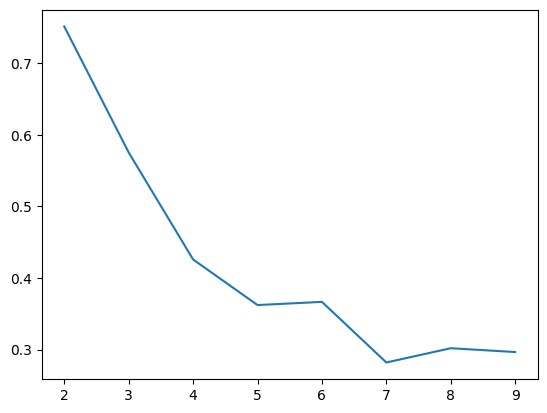

In [43]:
silhouette_avgs = []
for i in range(2,10):
    clustering_kmeans = KMeans(n_clusters=i)
    clusters = clustering_kmeans.fit_predict(pivoted_clustering)
    silhouette_avg = silhouette_score(pivoted_clustering, clusters)
    silhouette_avgs.append(silhouette_avg)
plt.plot(np.arange(2,len(silhouette_avgs)+2,1),silhouette_avgs)

In [44]:
#Choose k=6 bc max silhouette
#Drop cluster column if already run once
# pivoted_clustering = pivoted_clustering.drop('cluster',axis=1)
clustering_kmeans = KMeans(n_clusters=4)
clusters = clustering_kmeans.fit_predict(pivoted_clustering)
pivoted_clustering['cluster'] = clusters

In [45]:
#not a lot of float/cycles in 2 of the clusters, not good separation
pivoted_clustering['cluster'].value_counts()

0    40074
3    14822
1     3014
2      540
Name: cluster, dtype: int64

In [46]:
pivoted_clustering = pivoted_clustering.reset_index()
pivoted_clustering.head()

PRES_binned,float,cycleNumber,latitude,longitude,seasonality,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,cluster
0,1902303,1,49.236,-14.742,2,0.704058,0.702668,0.678800,0.668311,0.734552,0.932129,1.098108,0.814539,0.684214,0.449756,0.329485,0.240707,0.176219,0.123368,0.097569,0.091884,0.079771,0.060339,0.044660,0.031792,0.016426,0.003206,0.002011,0.002008,0.003052,0.004531,0.005329,0.005496,3
1,1902303,2,49.096,-14.617,2,0.691814,0.665761,0.750091,0.769773,0.838611,1.308873,1.385440,0.939163,0.647262,0.436683,0.292875,0.190597,0.152214,0.127053,0.106752,0.095180,0.071833,0.068459,0.093618,0.063899,0.024611,0.005835,0.002064,0.002270,0.002590,0.004308,0.000000,0.000000,3
2,1902303,3,48.914,-14.606,2,1.063866,1.064480,0.979005,0.942488,0.954018,1.222963,1.086416,0.848111,0.533261,0.302491,0.279124,0.278597,0.139859,0.102519,0.084580,0.065149,0.066523,0.054134,0.028856,0.025920,0.024346,0.005744,0.002388,0.002844,0.002375,0.004185,0.005217,0.005071,3
3,1902303,4,48.794,-14.689,2,1.432731,1.409791,1.424486,1.514563,1.416844,1.371946,0.883025,0.370423,0.146220,0.090078,0.063536,0.045722,0.037827,0.028262,0.025384,0.024358,0.016924,0.014488,0.010990,0.012739,0.009513,0.003165,0.003031,0.002826,0.002638,0.004544,0.005110,0.005549,1
4,1902303,5,48.719,-14.795,2,1.008395,1.038687,1.047004,1.039988,1.044929,1.022055,0.949463,0.244267,0.086929,0.062677,0.040376,0.027891,0.026661,0.034457,0.032853,0.032541,0.026794,0.022822,0.016300,0.013801,0.008198,0.003174,0.002918,0.003244,0.004026,0.004803,0.005358,0.005572,3


In [47]:
# cluster_df = df[['float','latitude','longitude','cycleNumber','PRES','PRES_binned','norm_CHLA']].merge(pivoted_clustering[['float','cycleNumber','cluster']], how='left',on=['float','cycleNumber'])
# cluster_df.head()

In [52]:
pivoted_clustering.head()

PRES_binned,float,cycleNumber,latitude,longitude,seasonality,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,cluster
0,1902303,1,49.236,-14.742,2,0.704058,0.702668,0.678800,0.668311,0.734552,0.932129,1.098108,0.814539,0.684214,0.449756,0.329485,0.240707,0.176219,0.123368,0.097569,0.091884,0.079771,0.060339,0.044660,0.031792,0.016426,0.003206,0.002011,0.002008,0.003052,0.004531,0.005329,0.005496,3
1,1902303,2,49.096,-14.617,2,0.691814,0.665761,0.750091,0.769773,0.838611,1.308873,1.385440,0.939163,0.647262,0.436683,0.292875,0.190597,0.152214,0.127053,0.106752,0.095180,0.071833,0.068459,0.093618,0.063899,0.024611,0.005835,0.002064,0.002270,0.002590,0.004308,0.000000,0.000000,3
2,1902303,3,48.914,-14.606,2,1.063866,1.064480,0.979005,0.942488,0.954018,1.222963,1.086416,0.848111,0.533261,0.302491,0.279124,0.278597,0.139859,0.102519,0.084580,0.065149,0.066523,0.054134,0.028856,0.025920,0.024346,0.005744,0.002388,0.002844,0.002375,0.004185,0.005217,0.005071,3
3,1902303,4,48.794,-14.689,2,1.432731,1.409791,1.424486,1.514563,1.416844,1.371946,0.883025,0.370423,0.146220,0.090078,0.063536,0.045722,0.037827,0.028262,0.025384,0.024358,0.016924,0.014488,0.010990,0.012739,0.009513,0.003165,0.003031,0.002826,0.002638,0.004544,0.005110,0.005549,1
4,1902303,5,48.719,-14.795,2,1.008395,1.038687,1.047004,1.039988,1.044929,1.022055,0.949463,0.244267,0.086929,0.062677,0.040376,0.027891,0.026661,0.034457,0.032853,0.032541,0.026794,0.022822,0.016300,0.013801,0.008198,0.003174,0.002918,0.003244,0.004026,0.004803,0.005358,0.005572,3


In [59]:
test = pivoted_clustering[pivoted_clustering['cluster']==1].set_index(['float','cycleNumber','latitude','longitude','seasonality'])
test2 = pivoted_clustering[pivoted_clustering['cluster']==2]
randomlist = random.sample(range(0, len(test)), 100)
randomlist2 = random.sample(range(0, len(test2)), 100)

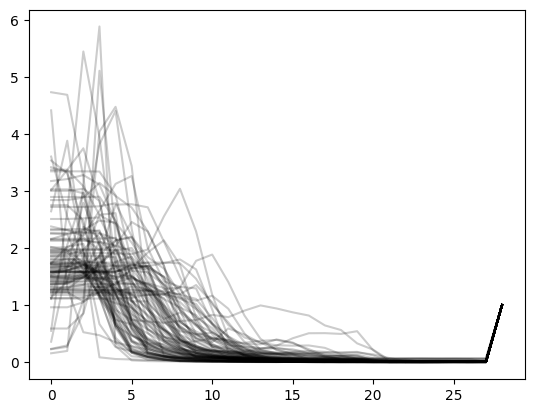

In [60]:
for i in randomlist:
        plt.plot(test.iloc[i].ravel(), "k-", alpha=.2)
# for j in randomlist2:
#         plt.plot(test.iloc[j].ravel(), color='green', alpha=.2)

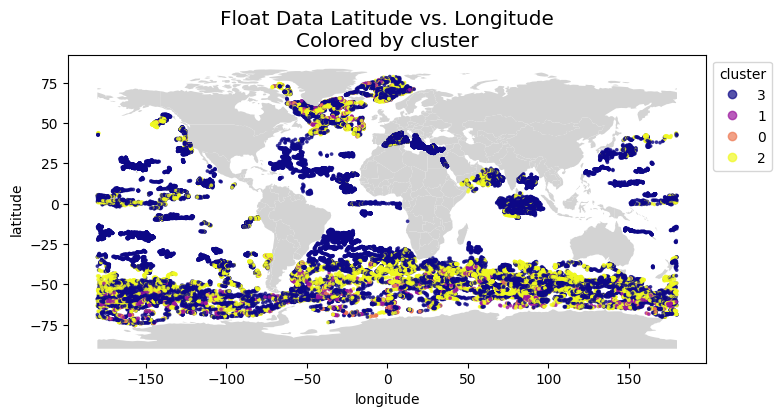

In [63]:

plot_on_map(
    df=pivoted_clustering,
    features='cluster',
    data_type='categorical',
    source='float',
    subtitle=None
)

## Kmeans cluster for each season

In [64]:
summer = pivoted_clustering[pivoted_clustering['seasonality'] ==3]
winter = pivoted_clustering[pivoted_clustering['seasonality'] ==1]
fall = pivoted_clustering[pivoted_clustering['seasonality'] ==4]
spring = pivoted_clustering[pivoted_clustering['seasonality'] ==2]
summer = summer.drop('seasonality',axis=1)

In [65]:
summer = summer.drop('cluster',axis=1)

In [66]:
summer = summer.set_index(['float','cycleNumber','latitude','longitude'])

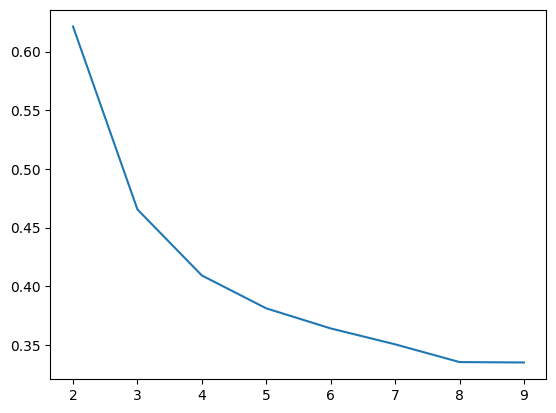

In [67]:
silhouette_avgs = []
for i in range(2,10):
    clustering_kmeans = KMeans(n_clusters=i)
    clusters = clustering_kmeans.fit_predict(summer)
    silhouette_avg = silhouette_score(summer, clusters)
    silhouette_avgs.append(silhouette_avg)
plt.plot(np.arange(2,len(silhouette_avgs)+2,1),silhouette_avgs)

In [239]:
#Choose k=4 bc high silhouette and makes sense
clustering_kmeans = KMeans(n_clusters=4)
clusters = clustering_kmeans.fit_predict(summer)
summer['cluster'] = clusters
summer = summer.reset_index()
summer.head()

,float,cycleNumber,latitude,longitude,1.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,2.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,cluster
0,1902303,28,47.098,-14.580,1.912850,0.086066,0.065876,0.054565,0.045597,0.042473,0.055716,0.049735,0.033603,0.025795,0.026544,2.252128,0.024920,0.011012,0.003404,0.003498,0.003438,0.004756,0.005695,0.006261,0.00609,1.519524,0.431693,0.256552,0.218994,0.189395,0.120973,0.113737,0
1,1902303,31,46.692,-14.513,0.702746,0.160580,0.118727,0.064512,0.045061,0.032166,0.016817,0.026294,0.023359,0.018986,0.016924,0.721148,0.016175,0.015050,0.006345,0.007648,0.000000,0.000000,0.000000,0.000000,0.00000,0.652486,0.697931,0.803890,0.779216,0.585100,0.383151,0.206422,0
2,1902303,32,46.642,-14.519,1.686908,0.079543,0.055919,0.045722,0.038600,0.030518,0.021984,0.015363,0.012802,0.010803,0.007492,1.399770,0.005852,0.005621,0.005337,0.003575,0.000000,0.000000,0.000000,0.000000,0.00000,0.719742,0.509750,0.469641,0.318680,0.234923,0.141327,0.101817,0
3,1902303,33,46.586,-14.525,0.341090,0.090503,0.054092,0.037320,0.030006,0.025607,0.020735,0.022536,0.020797,0.019173,0.018674,0.572919,0.014988,0.007336,0.004982,0.003978,0.000000,0.000000,0.000000,0.000000,0.00000,0.504544,0.564148,0.544914,0.513914,0.472270,0.306135,0.166749,2
4,1902303,34,46.543,-14.535,1.501445,0.091572,0.062879,0.044472,0.031993,0.022671,0.022109,0.020048,0.018294,0.009428,0.004743,1.292561,0.005306,0.006318,0.004593,0.003510,0.000000,0.000000,0.000000,0.000000,0.00000,0.665266,0.620863,0.542653,0.344552,0.247546,0.185652,0.095570,0


In [241]:
summer_cluster_df = df[['float','latitude','longitude','cycleNumber','PRES','PRES_binned','CHLA']].merge(summer[['float','cycleNumber','cluster']], how='inner',on=['float','cycleNumber'])
# summer_cluster_df.head()

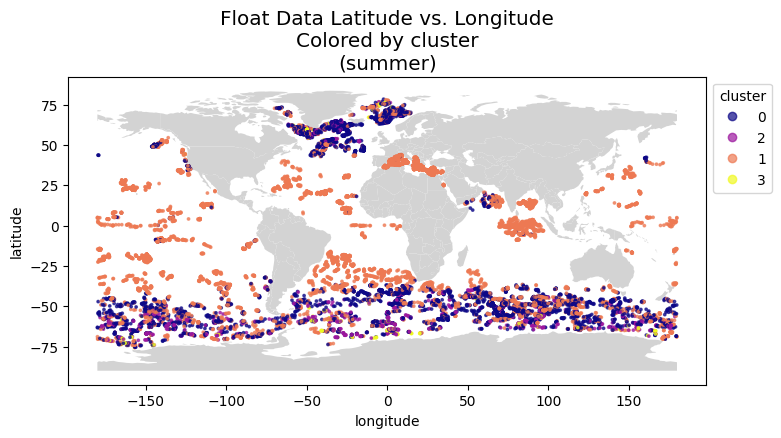

In [243]:
plot_on_map(
    df=summer,
    features='cluster',
    data_type='categorical',
    source='float',
    subtitle='summer'
)

In [244]:
test = summer_cluster_df[summer_cluster_df['cluster']==1]
test_float_cycle = test[['float','cycleNumber']].drop_duplicates()
test2 = summer_cluster_df[summer_cluster_df['cluster']==2]
test_float_cycle2 = test2[['float','cycleNumber']].drop_duplicates()
randomlist = random.sample(range(0, len(test_float_cycle)), 10)
randomlist2 = random.sample(range(0, len(test_float_cycle2)), 10)

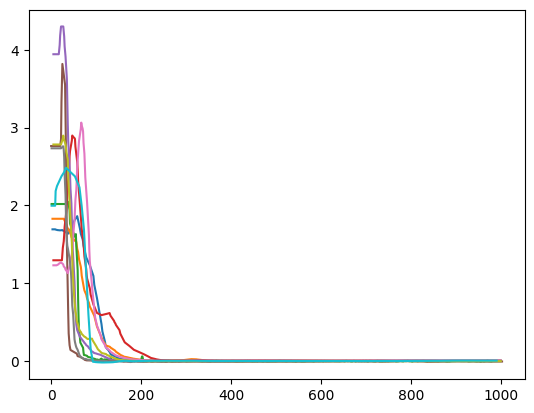

In [246]:
for i in randomlist:
    temp = test[(test['float'] == test_float_cycle.iloc[i]['float'])&(test['cycleNumber'] == test_float_cycle.iloc[i]['cycleNumber'])]
    plt.plot(temp['PRES'],temp['CHLA'])
    # plt.show()

In [87]:
# summer.to_csv('../../data/summer.csv')

### K-means on the first 200m of depth

In [261]:
summer.head()

,float,cycleNumber,latitude,longitude,1.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,2.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,cluster
0,1902303,28,47.098,-14.580,1.912850,0.086066,0.065876,0.054565,0.045597,0.042473,0.055716,0.049735,0.033603,0.025795,0.026544,2.252128,0.024920,0.011012,0.003404,0.003498,0.003438,0.004756,0.005695,0.006261,0.00609,1.519524,0.431693,0.256552,0.218994,0.189395,0.120973,0.113737,0
1,1902303,31,46.692,-14.513,0.702746,0.160580,0.118727,0.064512,0.045061,0.032166,0.016817,0.026294,0.023359,0.018986,0.016924,0.721148,0.016175,0.015050,0.006345,0.007648,0.000000,0.000000,0.000000,0.000000,0.00000,0.652486,0.697931,0.803890,0.779216,0.585100,0.383151,0.206422,0
2,1902303,32,46.642,-14.519,1.686908,0.079543,0.055919,0.045722,0.038600,0.030518,0.021984,0.015363,0.012802,0.010803,0.007492,1.399770,0.005852,0.005621,0.005337,0.003575,0.000000,0.000000,0.000000,0.000000,0.00000,0.719742,0.509750,0.469641,0.318680,0.234923,0.141327,0.101817,0
3,1902303,33,46.586,-14.525,0.341090,0.090503,0.054092,0.037320,0.030006,0.025607,0.020735,0.022536,0.020797,0.019173,0.018674,0.572919,0.014988,0.007336,0.004982,0.003978,0.000000,0.000000,0.000000,0.000000,0.00000,0.504544,0.564148,0.544914,0.513914,0.472270,0.306135,0.166749,2
4,1902303,34,46.543,-14.535,1.501445,0.091572,0.062879,0.044472,0.031993,0.022671,0.022109,0.020048,0.018294,0.009428,0.004743,1.292561,0.005306,0.006318,0.004593,0.003510,0.000000,0.000000,0.000000,0.000000,0.00000,0.665266,0.620863,0.542653,0.344552,0.247546,0.185652,0.095570,0


In [262]:
summer_short = summer.copy()
summer_short = summer_short.set_index(['float','cycleNumber','latitude','longitude'])
summer_short = summer_short[[str(float(item)) for item in np.arange(1,20,1)]]

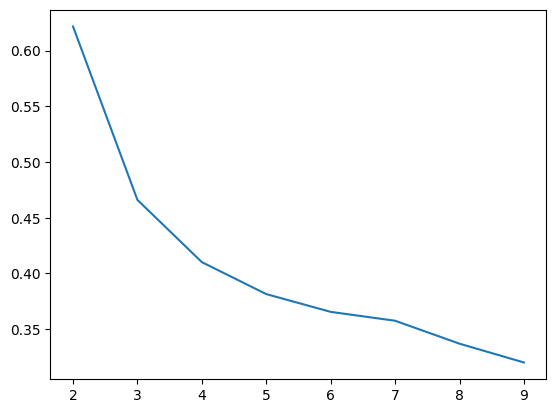

In [264]:
silhouette_avgs = []
for i in range(2,10):
    clustering_kmeans = KMeans(n_clusters=i)
    clusters = clustering_kmeans.fit_predict(summer_short)
    silhouette_avg = silhouette_score(summer_short, clusters)
    silhouette_avgs.append(silhouette_avg)
plt.plot(np.arange(2,len(silhouette_avgs)+2,1),silhouette_avgs)

In [265]:
#Choose k=4 bc max silhouette
clustering_kmeans = KMeans(n_clusters=4)
clusters = clustering_kmeans.fit_predict(summer_short)
summer_short['cluster'] = clusters
# summer_short = summer_short.reset_index()
summer_short.head()

1.0       2.0       3.0  \
float   cycleNumber latitude longitude                                 
1902303 28          47.098   -14.580    1.912850  2.252128  1.519524   
        31          46.692   -14.513    0.702746  0.721148  0.652486   
        32          46.642   -14.519    1.686908  1.399770  0.719742   
        33          46.586   -14.525    0.341090  0.572919  0.504544   
        34          46.543   -14.535    1.501445  1.292561  0.665266   

                                             4.0       5.0       6.0  \
float   cycleNumber latitude longitude                                 
1902303 28          47.098   -14.580    0.431693  0.256552  0.218994   
        31          46.692   -14.513    0.697931  0.803890  0.779216   
        32          46.642   -14.519    0.509750  0.469641  0.318680   
        33          46.586   -14.525    0.564148  0.544914  0.513914   
        34          46.543   -14.535    0.620863  0.542653  0.344552   

                                             7.0       8.0       9.0  \
float   cycleNumber latitude longitude                                 
1902303 28          47.098   -14.580    0.189395  0.120973  0.113737   
        31          46.692   -14.513    0.585100  0.383151  0.206422   
        32          46.642   -14.519    0.234923  0.141327  0.101817   
        33          46.586   -14.525    0.472270  0.306135  0.166749   
        34          46.543   -14.535    0.247546  0.185652  0.095570   

                                            10.0      11.0      12.0  \
float   cycleNumber latitude longitude                                 
1902303 28          47.098   -14.580    0.086066  0.065876  0.054565   
        31          46.692   -14.513    0.160580  0.118727  0.064512   
        32          46.642   -14.519    0.079543  0.055919  0.045722   
        33          46.586   -14.525    0.090503  0.054092  0.037320   
        34          46.543   -14.535    0.091572  0.062879  0.044472   

                                            13.0      14.0      15.0  \
float   cycleNumber latitude longitude                                 
1902303 28          47.098   -14.580    0.045597  0.042473  0.055716   
        31          46.692   -14.513    0.045061  0.032166  0.016817   
        32          46.642   -14.519    0.038600  0.030518  0.021984   
        33          46.586   -14.525    0.030006  0.025607  0.020735   
        34          46.543   -14.535    0.031993  0.022671  0.022109   

                                            16.0      17.0      18.0  \
float   cycleNumber latitude longitude                                 
1902303 28          47.098   -14.580    0.049735  0.033603  0.025795   
        31          46.692   -14.513    0.026294  0.023359  0.018986   
        32          46.642   -14.519    0.015363  0.012802  0.010803   
        33          46.586   -14.525    0.022536  0.020797  0.019173   
        34          46.543   -14.535    0.020048  0.018294  0.009428   

                                            19.0  cluster  
float   cycleNumber latitude longitude                     
1902303 28          47.098   -14.580    0.026544        3  
        31          46.692   -14.513    0.016924        3  
        32          46.642   -14.519    0.007492        3  
        33          46.586   -14.525    0.018674        1  
        34          46.543   -14.535    0.004743        3

In [266]:
test = summer_short[summer_short['cluster']==1]
# test_float_cycle = test[['float','cycleNumber']].drop_duplicates()
randomlist = random.sample(range(0, len(test)), 10)

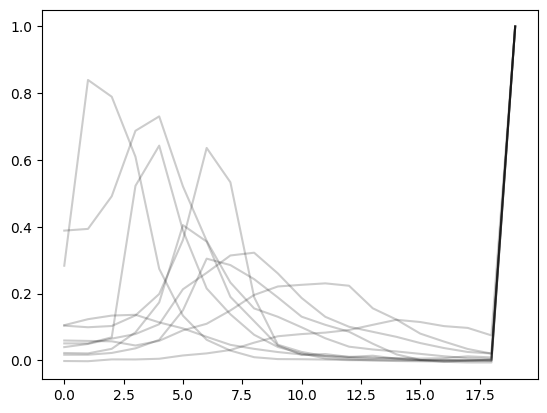

In [267]:
for j in randomlist:
        plt.plot(test.iloc[j].ravel(), "k-", alpha=.2)

In [270]:
summer_short = summer_short.reset_index()

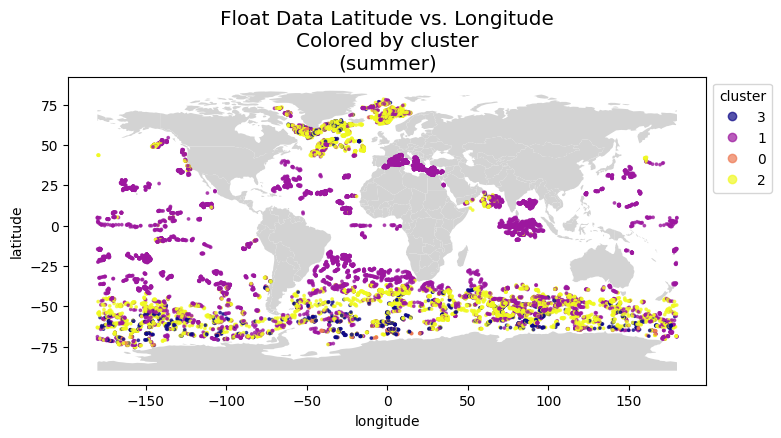

In [271]:
plot_on_map(
    df=summer_short,
    features='cluster',
    data_type='categorical',
    source='float',
    subtitle='summer'
)

# Hierarchical clustering

In [31]:
#Stopped after 239m - took way too long
clustering_hierarchical = AgglomerativeClustering(n_clusters=5)
clusters_hierarchical = clustering_hierarchical.fit_predict(pivoted_clustering)
silhouette_avg_hierarchical = silhouette_score(pivoted_clustering, clusters_hierarchical)
silhouette_avg_hierarchical


# Time series clustering

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [117]:
summer = summer.set_index(['float','cycleNumber','latitude','longitude'])
summer = summer.drop('cluster',axis=1)
#Reorder columns
summer = summer[[str(float(item)) for item in np.arange(1,29,1)]]
fall = fall.set_index(['float','cycleNumber','latitude','longitude'])
fall = fall.drop('cluster',axis=1)
#Reorder columns
fall = fall[[str(float(item)) for item in np.arange(1,29,1)]]

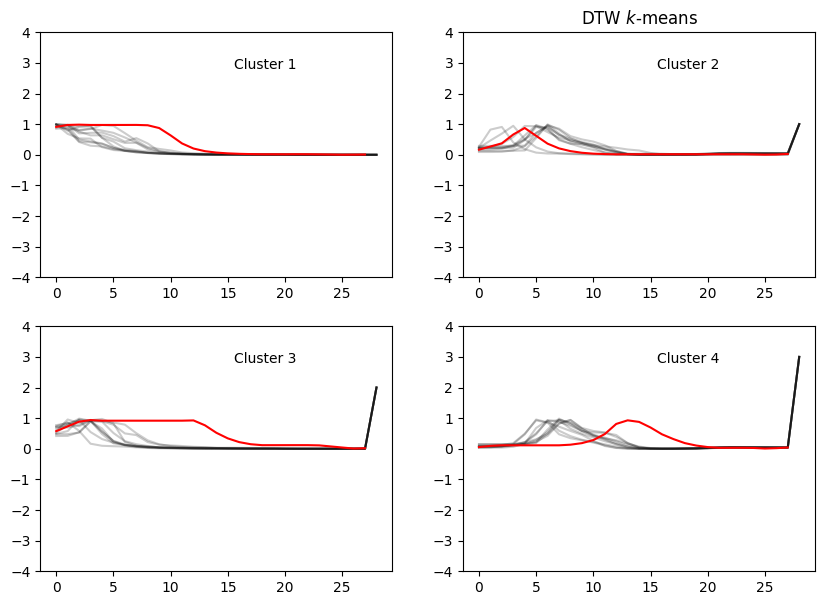

In [148]:
summer = summer.drop('cluster',axis=1)
model = TimeSeriesKMeans(n_clusters=4, metric="dtw",
                         max_iter=10, random_state=123)
cluster = model.fit_predict(summer)
summer['cluster'] = cluster
plt.figure(figsize=(10,7))
for i in range(4):
    plt.subplot(2,2, i + 1)
    for j in range(10):
        plt.plot(summer[cluster==i].iloc[j].ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[i].ravel(), "r-")
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 1:
        plt.title("DTW $k$-means")

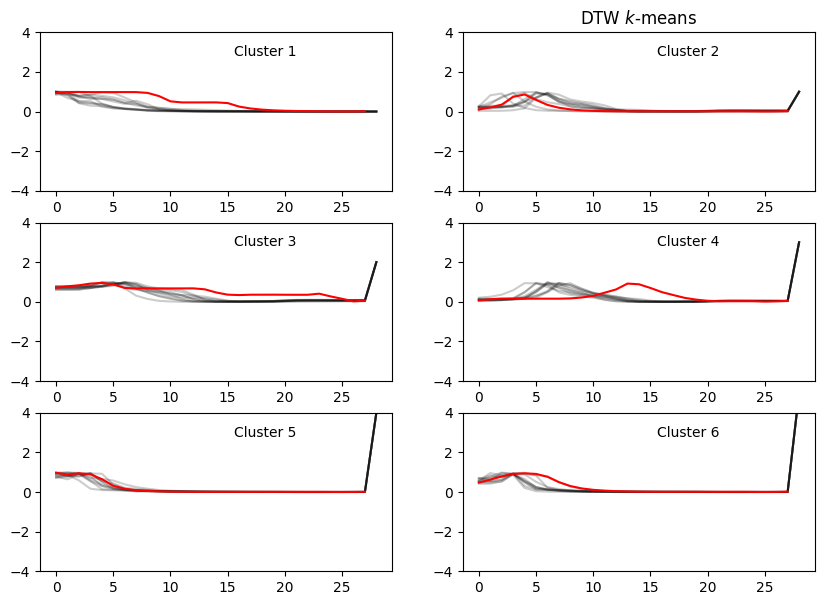

In [149]:
summer = summer.drop('cluster',axis=1)
model = TimeSeriesKMeans(n_clusters=6, metric="dtw",
                         max_iter=10, random_state=123)
cluster = model.fit_predict(summer)
summer['cluster'] = cluster
plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(3,2, i + 1)
    for j in range(10):
        plt.plot(summer[cluster==i].iloc[j].ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[i].ravel(), "r-")
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 1:
        plt.title("DTW $k$-means")

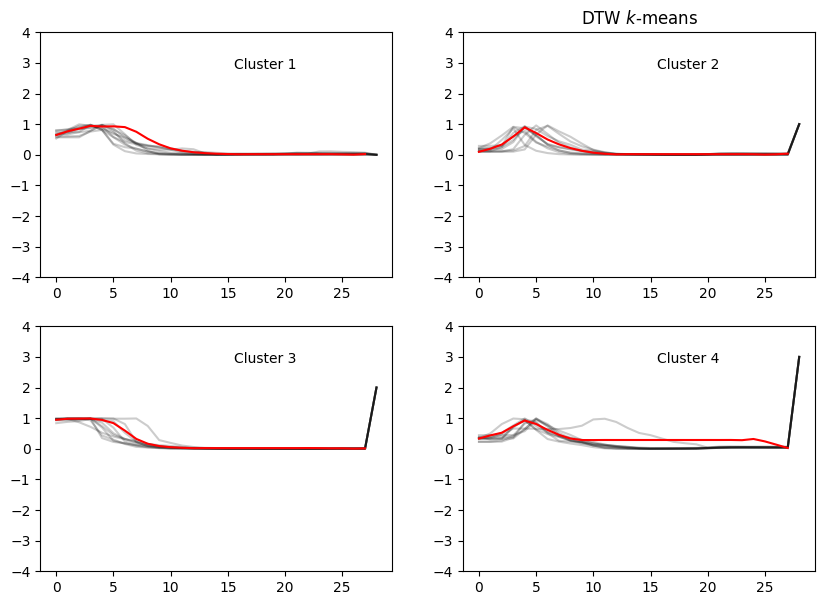

In [173]:
# fall = fall.drop('cluster',axis=1)
model = TimeSeriesKMeans(n_clusters=4, metric="dtw",
                         max_iter=10, random_state=123)
cluster = model.fit_predict(fall)
fall['cluster'] = cluster
plt.figure(figsize=(10,7))
for i in range(4):
    plt.subplot(2,2, i + 1)
    for j in range(10):
        plt.plot(fall[cluster==i].iloc[j].ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[i].ravel(), "r-")
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 1:
        plt.title("DTW $k$-means")

#### Cluster on first 200m

In [174]:
summer_short = summer[[str(float(item)) for item in np.arange(1,20,1)]]
fall_short = fall[[str(float(item)) for item in np.arange(1,20,1)]]

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_22618/1258163251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_short['cluster'] = cluster


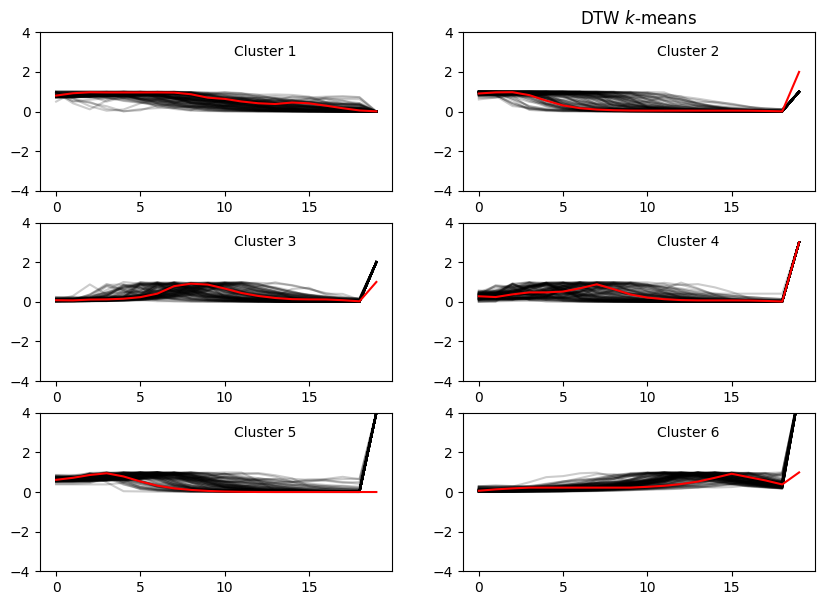

In [170]:
# summer_short = summer_short.drop('cluster',axis=1)
model = TimeSeriesKMeans(n_clusters=6, metric="dtw",
                         max_iter=10, random_state=123)
cluster = model.fit_predict(summer_short)
summer_short['cluster'] = cluster
plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(3,2, i + 1)
    random_list = random.sample(range(0, len(summer_short[cluster==i])), 100)
    for j in random_list:
        plt.plot(summer_short[cluster==i].iloc[j].ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[i].ravel(), "r-")
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 1:
        plt.title("DTW $k$-means")

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_22618/4215746222.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall_short['cluster'] = cluster


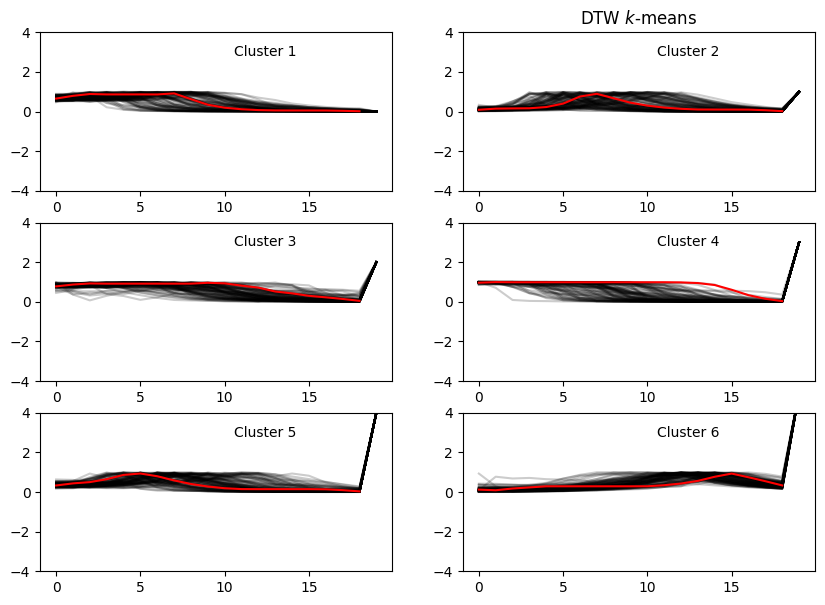

In [175]:
# fall_short = fall_short.drop('cluster',axis=1)
model = TimeSeriesKMeans(n_clusters=6, metric="dtw",
                         max_iter=10, random_state=123)
cluster = model.fit_predict(fall_short)
fall_short['cluster'] = cluster
plt.figure(figsize=(10,7))
for i in range(6):
    plt.subplot(3,2, i + 1)
    random_list = random.sample(range(0, len(fall_short[cluster==i])), 100)
    for j in random_list:
        plt.plot(fall_short[cluster==i].iloc[j].ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[i].ravel(), "r-")
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 1:
        plt.title("DTW $k$-means")